In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

**simulated annealing for our constrained case**

<ipython-input-60-b7ae11d9795f>:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_countries))


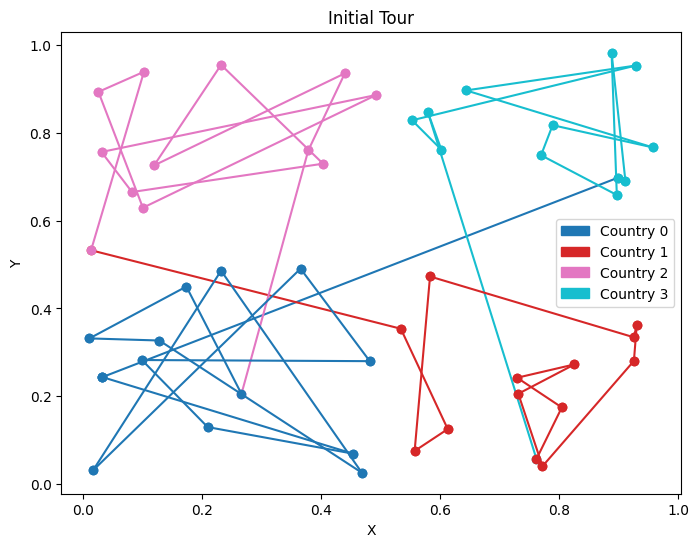

Optimal Cost: 7.6176344922867


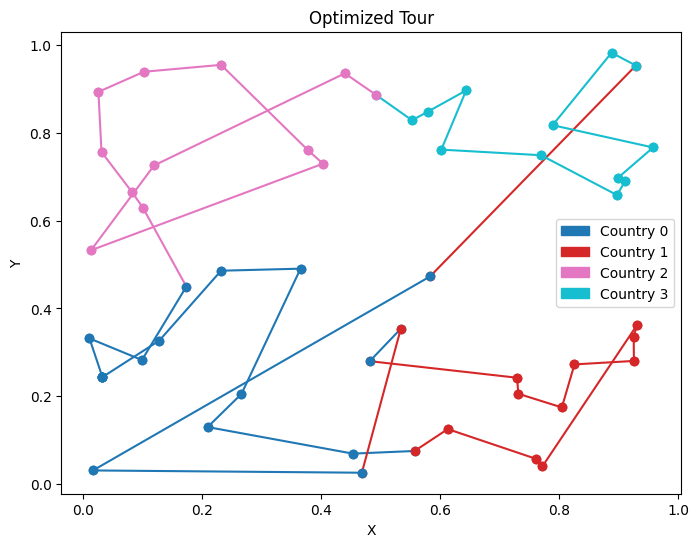

In [ ]:

class Salesman:
    def __init__(self, distance_matrix, countries):
        self.distance_matrix = distance_matrix
        self.countries = countries
        self.num_cities = len(distance_matrix)
        self.num_countries = len(set(countries))

        # initial config: random permutation of countries and permutation of tours within each country
        self.current_solution = self.generate_initial_solution()
        self.best_solution = self.current_solution[:]
        self.best_cost = self.compute_total_cost(self.current_solution)

    def generate_initial_solution(self):
        country_dict = {c: [] for c in set(self.countries)}
        for city, country in enumerate(self.countries):
            country_dict[country].append(city)

        country_order = list(country_dict.keys())
        random.shuffle(country_order)

        for country in country_order:
            random.shuffle(country_dict[country])  # randomize city ordering

        tour = []
        for country in country_order:
            tour.extend(country_dict[country])
        return [0] + tour + [0]

    def compute_total_cost(self, tour):
        return sum(self.distance_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1))

    def perturb(self):
        new_solution = self.current_solution[:]

        if random.random() < 0.5:
            country_list = list(set(self.countries))
            c1, c2 = random.sample(country_list, 2)

            indices_c1 = [i for i in range(len(new_solution)) if self.countries[new_solution[i]] == c1]
            indices_c2 = [i for i in range(len(new_solution)) if self.countries[new_solution[i]] == c2]

            # swapping segments corresponding to the two countries
            for idx_c1, idx_c2 in zip(indices_c1, indices_c2):
                new_solution[idx_c1], new_solution[idx_c2] = new_solution[idx_c2], new_solution[idx_c1]

        else:  # swapping two cities within the same country
            country = random.choice(list(set(self.countries)))
            country_cities = [i for i in range(len(new_solution)) if self.countries[new_solution[i]] == country]
            if len(country_cities) > 2:
                i, j = random.sample(country_cities, 2)
                new_solution[i], new_solution[j] = new_solution[j], new_solution[i]

        return new_solution

    def simulated_annealing(self, initial_temp=1000, cooling_rate=0.995, min_temp=1e-3, max_iter=10000000000):
        temperature = initial_temp
        iteration = 0

        while temperature > min_temp and iteration < max_iter:
            new_solution = self.perturb()
            new_cost = self.compute_total_cost(new_solution)
            cost_diff = new_cost - self.best_cost
            if cost_diff < 0 or random.random() < np.exp(-cost_diff / temperature):
                self.current_solution = new_solution[:]
                self.best_cost = new_cost
                self.best_solution = new_solution[:]

            temperature *= cooling_rate
            iteration += 1

        return self.best_solution, self.best_cost


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_tour(coordinates, tour, countries, title='Tour', annotate=False):
    if tour[0] != tour[-1]:
        closed_tour = tour + [tour[0]]
    else:
        closed_tour = tour[:]

    unique_countries = sorted(set(countries))
    cmap = plt.cm.get_cmap('tab10', len(unique_countries))
    country_to_color = {country: cmap(i) for i, country in enumerate(unique_countries)}

    plt.figure(figsize=(8, 6))

    for i in range(len(closed_tour) - 1):
        start = closed_tour[i]
        end = closed_tour[i+1]
        color = country_to_color[countries[start]]
        plt.plot([coordinates[start][0], coordinates[end][0]],
                 [coordinates[start][1], coordinates[end][1]],
                 color=color, marker='o')


    patches = [mpatches.Patch(color=country_to_color[c], label=f'Country {c}')
               for c in unique_countries]
    plt.legend(handles=patches)

    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()




def generate_random_cities(num_cities, num_countries, quadrant_based=False):
    if quadrant_based and num_countries == 4:
        # we want to have our countries take up different spaces on our plot
        base_count = num_cities // 4
        counts = [base_count] * 4
        remainder = num_cities - base_count * 4
        for i in range(remainder):
            counts[i] += 1

        coordinates = []
        countries = []
        for country in range(4):
            for _ in range(counts[country]):
                if country == 0:
                    x = np.random.uniform(0, 0.5)
                    y = np.random.uniform(0, 0.5)
                elif country == 1:
                    x = np.random.uniform(0.5, 1.0)
                    y = np.random.uniform(0, 0.5)
                elif country == 2:
                    x = np.random.uniform(0, 0.5)
                    y = np.random.uniform(0.5, 1.0)
                elif country == 3:
                    x = np.random.uniform(0.5, 1.0)
                    y = np.random.uniform(0.5, 1.0)
                coordinates.append([x, y])
                countries.append(country)
        coordinates = np.array(coordinates)
    else:
        coordinates = np.random.rand(num_cities, 2)
        countries = [random.randint(0, num_countries - 1) for _ in range(num_cities)]


    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = np.linalg.norm(coordinates[i] - coordinates[j])

    return coordinates, distance_matrix, countries


num_cities = 50
num_countries = 4

coordinates, distance_matrix, countries = generate_random_cities(num_cities, num_countries, quadrant_based=True)

ctsp = Salesman(distance_matrix, countries)

initial_tour = ctsp.current_solution
plot_tour(coordinates, initial_tour, countries, title='Initial Tour')

optimal_tour, optimal_cost = ctsp.simulated_annealing()
print("Optimal Cost:", optimal_cost)
plot_tour(coordinates, optimal_tour, countries, title='Optimized Tour')
